In [2]:
import pandas as pd
import numpy as np
from statsbombpy import sb

In [3]:
#get match ids
match_ids = sb.matches(season_id = 106, competition_id = 43)['match_id']

/Users/Eran/opt/anaconda3/lib/python3.8/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [123]:
#set number of events
n_events = 10

In [124]:
#for loop get all goals
final_results = pd.DataFrame()
events_to_delete = ['Foul Committed', 'Half End', 'Substitution', 'Bad Behaviour', 'Referee Ball-Drop'
                   'Player On', 'Player Off', 'Starting XI', 'Tactical Shift', 'Injury Stoppage', 'Player On', 'Player Off']

for selected_game in match_ids:
    df = sb.events(match_id=selected_game)

    # Delete rows with specific types
    df = df[~df['type'].isin(events_to_delete)]

    # Pass Types
    df.loc[(df['type'] == 'Pass') & (df['pass_switch'] == 'Free Kick'), 'type'] = 'Free Kick'
    df.loc[(df['type'] == 'Pass') & (df['pass_switch'] == 'Corner'), 'type'] = 'Corner'
    df.loc[(df['type'] == 'Pass') & (df['pass_switch'] == 'Kick Off'), 'type'] = 'Kick Off'
    df.loc[(df['type'] == 'Pass') & (df['pass_switch'] == 'Throw-in'), 'type'] = 'Throw-in'



    df.loc[(df['type'] == 'Pass') & (df['pass_switch'] == True), 'type'] = 'Switch Pass'
    df.loc[(df['type'] == 'Pass') & (df['pass_length'] >= 30), 'type'] = 'Long Pass'
    df.loc[(df['type'] == 'Pass') & (df['pass_length'] < 30), 'type'] = 'Short Pass'



    df.loc[(df['type'] == 'Long Pass') & (df['pass_cross'] == True), 'type'] = 'Long Cross'
    df.loc[(df['type'] == 'Short Pass') & (df['pass_cross'] == True), 'type'] = 'Short Cross'

    # Ball Receipt Success
    df.loc[(df['type'] == 'Ball Receipt*') & (df['ball_receipt_outcome'] != 'Incomplete'), 'type'] = 'Ball Receipt'
    df.loc[(df['type'] == 'Ball Receipt*') & (df['ball_receipt_outcome'] == 'Incomplete'), 'type'] = 'Ball Receipt - Incomplete'

    # Clearance Types
    df.loc[(df['type'] == 'Clearance') & (df['clearance_head'] == True), 'type'] = 'Clearance - Aerial'
    df.loc[(df['type'] == 'Clearance') & (df['clearance_head'] != True), 'type'] = 'Clearance - Kick'

    # Carries
    df.loc[(df['type'] == 'Carry') & ((df['carry_end_location'].str[0] - df['location'].str[0]).abs() > 20), 'type'] = 'Long Carry - X'
    df.loc[(df['type'] == 'Carry') & ((df['carry_end_location'].str[1] - df['location'].str[1]).abs() > 20), 'type'] = 'Long Carry - Y'
    df.loc[(df['type'] == 'Carry') & ((df['carry_end_location'].str[0] - df['location'].str[0]).abs() > 20) & ((df['carry_end_location'].str[1] - df['location'].str[1]).abs() > 20), 'type'] = 'Long Carry - Diagonal'

    # Dribbles
    df.loc[(df['type'] == 'Dribble') & (df['dribble_outcome'] == "Complete"), 'type'] = 'Dribble Successful'
    df.loc[(df['type'] == 'Dribble') & (df['dribble_outcome'] == "Incomplete"), 'type'] = 'Dribble - Unsuccessful'

    # Duels
    df.loc[(df['type'] == 'Duel') & (~df['duel_outcome'].isna()), 'type'] = df['duel_type'] + ' - ' + df['duel_outcome']
    df.loc[(df['type'] == 'Duel') & (df['duel_outcome'].isna()), 'type'] = df['duel_type']

    # Goalkeeper
    df.loc[df['type'] == 'Goal Keeper', 'type'] = df['goalkeeper_type']


    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['period', 'timestamp', 'id']) # type: ignore
    df = df.reset_index(drop=True)
    goal_entries = df[df['shot_outcome'] == 'Goal']
    extracted_entries = []

    for index, goal_row in goal_entries.iterrows():
        goal_index = index
        start_index = max(0, goal_index - n_events) # type: ignore
        end_index = goal_index + 1 # type: ignore
        previous_entries = df.iloc[start_index:end_index]
        extracted_entries.extend(previous_entries.values.tolist())

    columns = df.columns
    last_events = pd.DataFrame(extracted_entries, columns=columns)
    final_results = final_results.append(last_events, ignore_index=True) # type: ignore
    

/Users/Eran/opt/anaconda3/lib/python3.8/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
#turn all goals into cool dfs
num_columns = 11
num_rows = len(final_results) // num_columns
complete_df = pd.DataFrame(columns=[f'event_{i+1}' for i in range(num_columns)])

for i in range(num_rows):
    start_idx = i * num_columns
    end_idx = start_idx + num_columns
    events = final_results['type'][start_idx:end_idx].tolist()
    last_team = final_results['team'].iloc[end_idx-1]
    events = [f'{event} S' if team == last_team else f'{event} C' for event, team in zip(events, final_results['team'][start_idx:end_idx].tolist())]
    complete_df.loc[i] = events # type: ignore



In [ ]:

pd.set_option('display.max_columns', None)
complete_df.iloc[10:20]


,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11
10,Short Pass S,Ball Receipt S,Carry S,Long Pass S,Ball Receipt S,Carry S,Short Pass S,Ball Receipt - Incomplete S,Block C,Ball Recovery S,Shot S
11,Pressure C,Pressure S,Foul Won S,Long Pass S,Ball Receipt - Incomplete S,Interception C,Pressure C,Ball Recovery S,Carry S,Foul Won S,Shot S
12,Ball Receipt S,Pressure C,Foul Won S,Short Pass S,Clearance - Aerial C,Long Pass S,Ball Receipt S,Shot S,Shot Faced C,Ball Recovery S,Shot S
13,Carry S,Ball Recovery S,Short Pass S,Ball Receipt S,Carry S,Pressure C,Foul Won S,Long Cross S,Clearance - Kick C,Ball Recovery S,Shot S
14,Pressure C,Pressure C,Short Pass S,Ball Receipt S,Long Carry - Y S,Short Pass S,Carry S,Ball Receipt S,Pressure C,Pressure C,Shot S
15,Clearance - Kick C,Long Pass S,Ball Receipt S,Pressure C,Short Pass S,Long Carry - X S,Ball Receipt S,Pressure C,Pressure C,Foul Won S,Shot S
16,Ball Recovery S,Carry S,Short Pass S,Carry S,Ball Receipt S,Short Pass S,Carry S,Ball Receipt S,Long Cross S,Ball Receipt S,Shot S
17,Ball Receipt S,Carry S,Pressure C,Short Pass S,Clearance - Aerial C,Foul Won S,Short Pass S,Ball Receipt S,Carry S,Pressure C,Shot S
18,Ball Recovery S,Ball Receipt - Incomplete C,Short Pass S,Ball Receipt S,Carry S,Short Pass S,Half Start C,Half Start S,Shot C,Penalty Saved S,Shot S
19,Carry S,Short Pass S,Half Start C,Half Start S,Shot C,Penalty Saved S,Shot S,Penalty Conceded C,Shot C,Penalty Saved S,Shot S


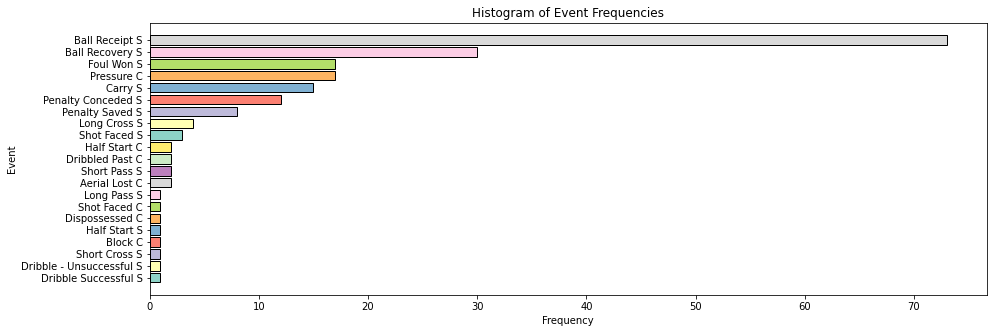

In [ ]:
#wowz
import matplotlib.pyplot as plt
from palettable import colorbrewer

num_bins = len(complete_df['event_10'].unique())
event_counts = complete_df['event_10'].value_counts().sort_values(ascending=True)
events = event_counts.index.tolist()
frequencies = event_counts.tolist()

colors = colorbrewer.qualitative.Set3_12.mpl_colors # type: ignore
plt.barh(events, frequencies, color=colors, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Event')
plt.title('Histogram of Event Frequencies')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

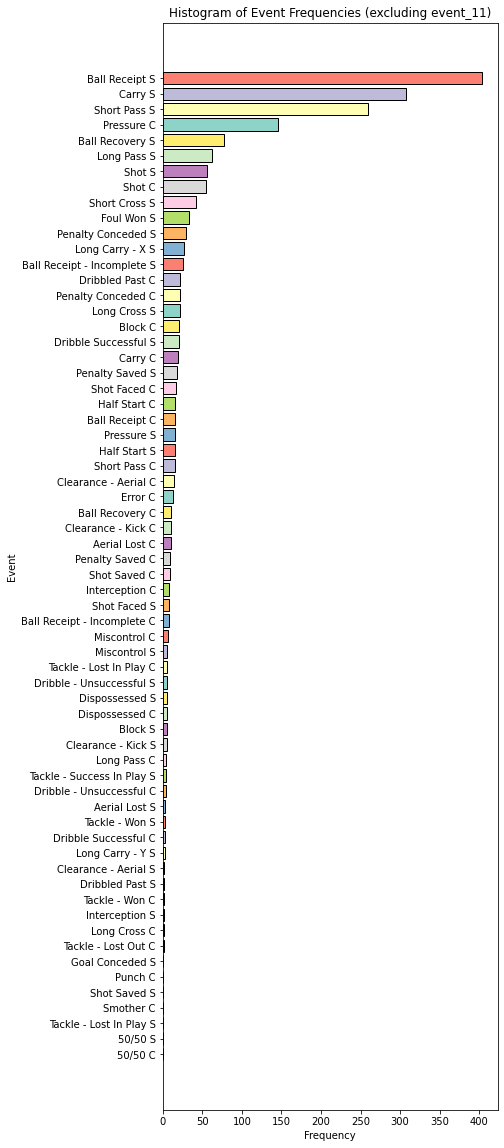

In [ ]:
num_bins = len(complete_df.columns) - 1
event_counts = complete_df.drop(columns=['event_11']).apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=True)
events = event_counts.index.tolist()
frequencies = event_counts.tolist()

colors = colorbrewer.qualitative.Set3_12.mpl_colors # type: ignore
plt.barh(events, frequencies, color=colors, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Event')
plt.title('Histogram of Event Frequencies (excluding event_11)')
plt.rcParams['figure.figsize'] = [7, 20]
plt.show()

